In [1]:
import numpy as np
import matplotlib.pyplot as plt
from prep_data import *

In [2]:
train_data = AttributeSet(train=True)

In [3]:
test_data = AttributeSet(train=False)

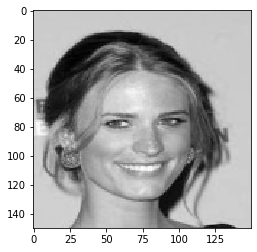

In [15]:
# viz the data
plt.imshow(train_data[20][0], cmap='gray')
plt.show()

In [16]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [44]:
# let's try building a convolutional model, which outputs a grid of 14x14x40 for each grid

class GridModel(nn.Module):
    def __init__(self, in_channels):
        super(GridModel, self).__init__()
        
        # 1x150x150
        self.conv1 = nn.Conv2d(in_channels, 16, 3)
        # 16x148x148
        # 16x74x74
        self.conv2 = nn.Conv2d(16, 32, 3)
        # 32x72x72
        # 32x36x36
        self.conv3 = nn.Conv2d(32, 64, 5)
        # 64x32x32
        # 64x16x16
        self.conv4 = nn.Conv2d(64, 128, 5)
        # 128x12x12
        self.conv5 = nn.Conv2d(128, 128, 3)
        # 128x10x10
        # 128x5x5
        self.conv6 = nn.Conv2d(128, 40, 5)
        # 40x1x1
        
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.maxpool(F.relu(self.conv5(x)))
        x = self.conv6(x)
        
        return torch.sigmoid(x)

In [23]:
example_input = next(iter(train_loader))
example_input[0].shape

torch.Size([64, 150, 150])

In [45]:
model = GridModel(1)
model

GridModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 40, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [46]:
out = model(example_input[0].view(64, 1, 150, 150).float())
out.squeeze()

tensor([[0.5011, 0.4989, 0.5021,  ..., 0.5013, 0.5020, 0.5034],
        [0.5012, 0.4990, 0.5020,  ..., 0.5013, 0.5018, 0.5032],
        [0.5010, 0.4989, 0.5021,  ..., 0.5013, 0.5020, 0.5033],
        ...,
        [0.5010, 0.4990, 0.5020,  ..., 0.5012, 0.5018, 0.5034],
        [0.5010, 0.4990, 0.5019,  ..., 0.5016, 0.5018, 0.5034],
        [0.5012, 0.4990, 0.5019,  ..., 0.5014, 0.5018, 0.5033]],
       grad_fn=<SqueezeBackward0>)

In [35]:
example_input[1]

tensor([[0, 0, 1,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        ...,
        [0, 0, 1,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]])

In [48]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
criterion(out.squeeze(), example_input[1].float())

tensor(0.6933, grad_fn=<BinaryCrossEntropyBackward>)

In [55]:
EPOCHS = 5

from tqdm import tqdm

loss_history = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    running_loss = 0.0
    for i, dat in enumerate(train_loader):
        inp, labels = dat
        model.zero_grad()
        out = model(inp.view(-1, 1, 150, 150).float())
        loss = criterion(out.squeeze(), labels.float())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 50 == 49:
            print(f'Epoch {epoch + 1}, Batch Size {i+1}, Running Loss {running_loss/i+1}')
            loss_history.append(running_loss/i+1)
    print(f'Epoch Loss {loss.item()}')

Epoch 1/5
Epoch 1, Batch Size 50, Running Loss 1.4689858835570666
Epoch 1, Batch Size 100, Running Loss 1.4478606834556116
Epoch 1, Batch Size 150, Running Loss 1.4410455804943239
Epoch Loss 0.4177824556827545
Epoch 2/5
Epoch 2, Batch Size 50, Running Loss 1.4373140821651536
Epoch 2, Batch Size 100, Running Loss 1.4329734465690573
Epoch 2, Batch Size 150, Running Loss 1.4298726296264852
Epoch Loss 0.4148022532463074
Epoch 3/5
Epoch 3, Batch Size 50, Running Loss 1.4166824884560643
Epoch 3, Batch Size 100, Running Loss 1.3983781536420186
Epoch 3, Batch Size 150, Running Loss 1.385557880937653
Epoch Loss 0.3458947539329529
Epoch 4/5
Epoch 4, Batch Size 50, Running Loss 1.333715084255958
Epoch 4, Batch Size 100, Running Loss 1.326729735942802
Epoch 4, Batch Size 150, Running Loss 1.3217273860569767
Epoch Loss 0.31574806571006775
Epoch 5/5
Epoch 5, Batch Size 50, Running Loss 1.2991690355904248
Epoch 5, Batch Size 100, Running Loss 1.2953885829809941
Epoch 5, Batch Size 150, Running Loss 1

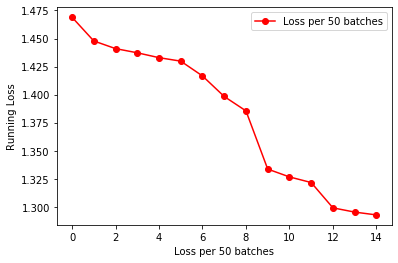

In [56]:
# Total Loss Plot
plt.plot(loss_history, 'ro-', label='Loss per 50 batches')
plt.xlabel('Loss per 50 batches')
plt.ylabel('Running Loss')
plt.legend()
plt.show()

In [57]:
# evaluating the model
test_input = next(iter(test_loader))
out = model(test_input[0].view(-1, 1, 150, 150).float())

In [71]:
out_ = out.squeeze().to(torch.int64)
sum(sum(out_ == test_input[1])).item() / (out_.size(0) * out_.size(1))

0.766796875

In [73]:
with torch.no_grad():
    correct = 0
    total = 0
    for inp, label in test_loader:
        out = model(inp.view(-1, 1, 150, 150).float())
        out = out.squeeze().to(torch.int64)
        correct += (sum(sum(out == label))).item()
        total += out.size(0) * out.size(1)
    print(f'Model Test Accuracy {round(correct/total, 4) * 100.0}%')

Model Test Accuracy 77.47%


In [74]:
# not bad
# let's try with custom images

In [80]:
from IPython.core.display import display, HTML

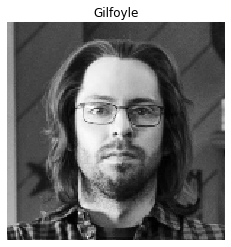

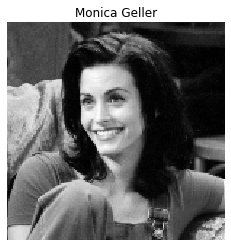

In [118]:
gilf = cv2.imread('./custom_inputs/gilf.jpg', cv2.IMREAD_GRAYSCALE)
mon = cv2.imread('./custom_inputs/mon.jpg', cv2.IMREAD_GRAYSCALE)
gilf = cv2.resize(gilf, (150, 150))
mon = cv2.resize(mon, (150, 150))

gilf = gilf / 255.0
mon = mon / 255.0

plt.axis('off')
plt.title('Gilfoyle')
plt.imshow(gilf, cmap='gray')
plt.show()

plt.axis('off')
plt.title('Monica Geller')
plt.imshow(mon, cmap='gray')
plt.show()

In [109]:
gilf = torch.Tensor(gilf)
mon = torch.Tensor(mon)

In [84]:
import pandas as pd

cols = pd.read_csv('../data/list_attr_celeba.csv').columns.tolist()[1:]

In [110]:
gilf_out = model(gilf.view(-1, 1, 150, 150).float())
mon_out = model(mon.view(-1, 1, 150, 150).float())

In [111]:
gilf_out = (gilf_out.squeeze() > 0.5).to(torch.int64)
mon_out = (mon_out.squeeze() > 0.5).to(torch.int64)

In [112]:
gilf_out_features = [cols[i] for i in range(len(cols)) if gilf_out[i]]
mon_out_features = [cols[i] for i in range(len(cols)) if mon_out[i]]

# Custom Dataset Outputs

In [113]:
display(HTML('<h3>Gilfoyle</h3>'))
print(gilf_out_features)

['Big_Nose', 'Goatee', 'Male', 'Mustache', 'Sideburns', 'Wearing_Hat']


In [114]:
display(HTML('<h3>Monica Geller</h3>'))
print(mon_out_features)

['No_Beard', 'Wavy_Hair', 'Young']
